# Introduction

This is a simple demonstration of how word embedding works in tensorflow 2.0. The implementation is directly based on this tutorial paper:
- [word2vec Parameter Learning Explained](https://arxiv.org/abs/1411.2738)
- and its online demo [wevi](https://ronxin.github.io/wevi/)

which are based on these two pioneering works:
- [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781)
- [Distributed Representations of Words and Phrases and their Compositionality](https://arxiv.org/abs/1310.4546)

The [wevi](https://ronxin.github.io/wevi/) demo has already given an amazing visualization of word embedding. This project tries to replicate its result using Tensorflow 2.x, which is more practical, and whose code can be reused in the future work.

# Environment
The code is tested under these packages:
- Python 3.6
- numpy 1.17.2
- sklearn 0.21.3
- matplotlib 3.1.1
- tensorflow 2.0.0

# 0 - Prerequisite
The words/vocabulary/symbols are tokenized and converted into one-hot vector, before starting any of these embedding process.

Here are a list of imports and functions needed.

In [1]:
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import tensorflow as tf

%matplotlib inline
print('Check tf version is 2.x:', tf.__version__)

from nn import autoencoder_1hid, train, plot_enc_2d, nHotEncoder

Check tf version is 2.x: 2.0.0


# 1 - Simple Autoencoder
The simpliest Autoencoder is a 3 layer full connection neural network, with the input size same as the output. Training data and labels are the same, i.e., an Autoencoder tries to copy its input to its output. The value of hidden layer is then the encoding of the input.

Corresponding to the "self-loop" in wevi demostration.

## 1.1 - Dataset

In [2]:
# unrelated words
vocab = ['Alpha', 'Bravo', 'Charlie', 'Delta','Echo']
vocab = [[vocab[i]] for i in range(len(vocab))]
print("Data and labels are the same:\n", vocab)

Data and labels are the same:
 [['Alpha'], ['Bravo'], ['Charlie'], ['Delta'], ['Echo']]


In [3]:
# one-hot encoding
ohot = OneHotEncoder(dtype='float32')
X_vec = ohot.fit_transform(vocab)
Y_vec = X_vec.copy()
print('After Onehot, dataset is a sparse matrix with shape:', X_vec.shape)
print(X_vec.toarray())

After Onehot, dataset is a sparse matrix with shape: (5, 5)
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


## 1.2 - Model, Training and Evaluation

The hidden layer has no activation, meaning that it's a linear transformation. The result proves it's effective enough.

In [4]:
model = autoencoder_1hid(n_input=5, n_hidden=2)
model.summary()
# print out the init values
# print('\nPredicting output with random init weights:')
# print(model.predict(X))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Dense)              (None, 2)                 12        
_________________________________________________________________
decoder (Dense)              (None, 5)                 15        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


**Training process** uses mean square error and gradient descent. No fancy early-stopping or other gimmicks here.

Note:
- ```model(X)``` and ```model.predict(X)``` are different, one outputs tensor and the other np.array.
- modify ```learning_rate``` and ```epochs``` to change the duration of training.

Epoch:100, loss = 0.03103
Epoch:200, loss = 0.00313
Epoch:300, loss = 0.00106
Epoch:400, loss = 0.00058
Epoch:500, loss = 0.00039
Epoch:600, loss = 0.00029
Epoch:700, loss = 0.00022
Epoch:800, loss = 0.00018
Epoch:900, loss = 0.00015
Epoch:1000, loss = 0.00013

Plotting the loss value:


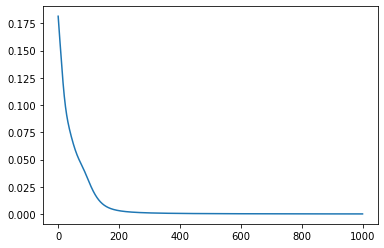

In [5]:
train(model, X_vec, Y_vec, n_epochs=1000, learning_rate=2.0)

Now input the training data X and see the output. After converting back to labels, they match exactly with input (A,B,C,D,E).

In [6]:
# Evaluation 
print('Output for the vocabulary:')
print(model.predict(X_vec))
print('Transform back to labels:')
print(ohot.inverse_transform(model.predict(X_vec)))

Output for the vocabulary:
[[9.8410231e-01 5.8729832e-08 1.4383970e-02 4.4215389e-07 1.5130802e-03]
 [8.0427895e-08 9.8500949e-01 1.1657057e-05 1.3496849e-02 1.4818844e-03]
 [1.4044151e-02 3.0685587e-05 9.7200686e-01 1.3830708e-02 8.7482404e-05]
 [5.3999457e-07 1.0275642e-02 1.2637755e-02 9.7708249e-01 3.5728224e-06]
 [9.4111683e-03 8.1280349e-03 1.8184686e-04 2.1994416e-05 9.8225695e-01]]
Transform back to labels:
[['Alpha']
 ['Bravo']
 ['Charlie']
 ['Delta']
 ['Echo']]


## 1.3 - Visualize Encoding
Here we build another model that is identical to the left half of the neural network. Its output will be the encoding of given word.

In [7]:
# encoding model
enc_model = tf.keras.Model(inputs=model.input,
                           outputs=model.get_layer('encoder').output)
X_enc = enc_model.predict(X_vec)
print("The encoding for all 5 words:")
print(X_enc)

The encoding for all 5 words:
[[-3.03541     0.94428337]
 [ 2.8545506   0.16601548]
 [-1.4332931  -1.5552611 ]
 [ 1.3547835  -2.4870684 ]
 [ 0.12725832  2.3160148 ]]


The 2D encoding of A,B,C,D,E are fairly split apart.


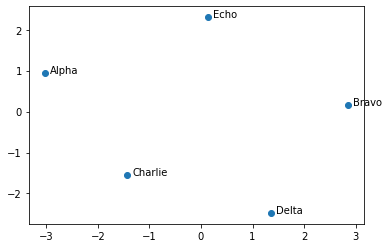

In [8]:
# plotting
plot_enc_2d(X_enc, vocab)
print('The 2D encoding of A,B,C,D,E are fairly split apart.')

# 2 - AutoEncoder with context
Still in AutoEncoder form, but the values of input & output is not the same, but have some relation.

Corresponding to the "fruit and juice" in wevi demostration.

## 2.1 - Dataset
This time vocabulary is different from training data.

In [9]:
# related words
vocab = ['apple', 'drink', 'eat', 'juice', 'milk', 'orange', 'rice', 'water']
vocab = [[_] for _ in vocab]    # sk.OneHotEncoder requires shape (n,1), not (n, )
print('vocabulary:', vocab)

vocabulary: [['apple'], ['drink'], ['eat'], ['juice'], ['milk'], ['orange'], ['rice'], ['water']]


In [10]:
# context-target dataset, copied from wevi
dataset = 'eat|apple,eat|orange,eat|rice,drink|juice,drink|milk,drink|water,orange|juice,\
apple|juice,rice|milk,milk|drink,water|drink,juice|drink'
dataset = dataset.split(',')
dataset = [pair.split('|') for pair in dataset]
X,Y = [[pair[0]] for pair in dataset], [[pair[1]] for pair in dataset]

print('dataset: {} samples.'.format(len(X)))
print('context  \t target')
for x_, y_ in zip(X,Y):
    print(x_, '\t', y_)

dataset: 12 samples.
context  	 target
['eat'] 	 ['apple']
['eat'] 	 ['orange']
['eat'] 	 ['rice']
['drink'] 	 ['juice']
['drink'] 	 ['milk']
['drink'] 	 ['water']
['orange'] 	 ['juice']
['apple'] 	 ['juice']
['rice'] 	 ['milk']
['milk'] 	 ['drink']
['water'] 	 ['drink']
['juice'] 	 ['drink']


In [11]:
# Onehot Encoding
ohot = OneHotEncoder(dtype='float32')
ohot.fit(vocab) 
X_vec = ohot.transform(X)
Y_vec = ohot.transform(Y)
print('shape of onehot:', X_vec.shape, Y_vec.shape)

shape of onehot: (12, 8) (12, 8)


## 2.2 - Model, Training and Evaluation

In [12]:
model = autoencoder_1hid(n_input=8, n_hidden=2)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Dense)              (None, 2)                 18        
_________________________________________________________________
decoder (Dense)              (None, 8)                 24        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


Epoch:100, loss = 0.08317
Epoch:200, loss = 0.06429
Epoch:300, loss = 0.05267
Epoch:400, loss = 0.04634
Epoch:500, loss = 0.04412
Epoch:600, loss = 0.04320
Epoch:700, loss = 0.04267
Epoch:800, loss = 0.04236
Epoch:900, loss = 0.04218
Epoch:1000, loss = 0.04206

Plotting the loss value:


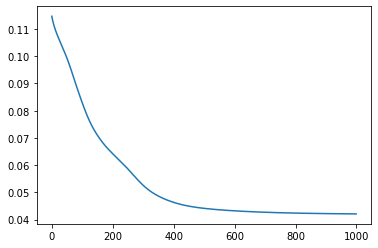

In [13]:
train(model, X_vec, Y_vec, n_epochs=1000, learning_rate=2.0)

Now input the training data X and see the output. After converting back to labels, we notice some are not matching.

In [14]:
print('Result after training:')
print('input   \t ground truth\t prediction')
for x_, y_, y_pred in zip(X, Y, ohot.inverse_transform(model.predict(X_vec))):
    print(x_, '\t', y_,'\t',y_pred, end='\t')
    if y_ == y_pred: print()
    else: print('*')

Result after training:
input   	 ground truth	 prediction
['eat'] 	 ['apple'] 	 ['rice']	*
['eat'] 	 ['orange'] 	 ['rice']	*
['eat'] 	 ['rice'] 	 ['rice']	
['drink'] 	 ['juice'] 	 ['milk']	*
['drink'] 	 ['milk'] 	 ['milk']	
['drink'] 	 ['water'] 	 ['milk']	*
['orange'] 	 ['juice'] 	 ['juice']	
['apple'] 	 ['juice'] 	 ['juice']	
['rice'] 	 ['milk'] 	 ['milk']	
['milk'] 	 ['drink'] 	 ['drink']	
['water'] 	 ['drink'] 	 ['drink']	
['juice'] 	 ['drink'] 	 ['drink']	


That is because some words have 1-to-3 relationships (eat - apple/orange/rice) that cannot be fully interpreted by top-1 prediction. Now take a look at detailed predictions of a single word.

In [15]:
word = 'eat'   # change this

print('The prediction scores for the word "{}":\n'.format(word))
print('--output--\t--score--')
scores = model.predict(ohot.transform([[word]]))[0]
for label_, score_ in zip(vocab, scores):
    print(label_, '\t{:.4f}'.format(score_), end='\t')
    if score_ > 1.0/8: print('*')
    else: print()
print('\nTherefore, the network successfully models 1-to-many relations.')

The prediction scores for the word "eat":

--output--	--score--
['apple'] 	0.3168	*
['drink'] 	0.0185	
['eat'] 	0.0028	
['juice'] 	0.0241	
['milk'] 	0.0001	
['orange'] 	0.3168	*
['rice'] 	0.3169	*
['water'] 	0.0040	

Therefore, the network successfully models 1-to-many relations.


## 2.3 - Visualize Encoding
Here we build another model that is identical to the left half of the neural network. Its output will be the encoding of given word.

In [16]:
# encoding model
enc_model = tf.keras.Model(inputs=model.input,
                           outputs=model.get_layer('encoder').output)
vocab_enc = enc_model.predict(ohot.transform(vocab))
print('Encoding of all 8 words:', vocab_enc.shape)
for word, enc in zip(vocab, vocab_enc):
    print(word, '\t', enc)

Encoding of all 8 words: (8, 2)
['apple'] 	 [ 1.3598071 -1.4174602]
['drink'] 	 [-0.08283938 -1.0273536 ]
['eat'] 	 [1.3996859 1.6223305]
['juice'] 	 [-1.5327166   0.55381745]
['milk'] 	 [-1.0998746  1.0112183]
['orange'] 	 [ 1.4642426 -1.2557164]
['rice'] 	 [-1.59028  -2.069116]
['water'] 	 [-1.2731768   0.84639347]


This 2D encoding shows word relationship.


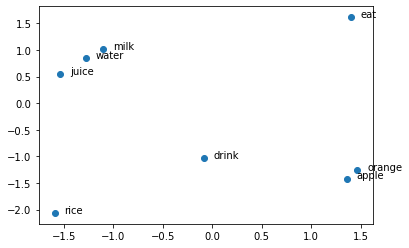

In [17]:
plot_enc_2d(vocab_enc, vocab)
print('This 2D encoding shows word relationship.')

# 3 - Skip-gram model
In skip-gram, input and output still have same size, but now allow output to have more 1's in the "one-hot" vector.

## 3.1 - Dataset
the dataset is generated by context word, e.g.:
- "drink apple juice" => target "drink", context "apple" "juice"

Since we are dealing with multiple labels, "n-hot" is needed

In [18]:
# context / target, copied from wevi
vocab = ['apple', 'drink', 'eat', 'juice', 'milk', 'orange', 'rice', 'water']
print('vocabulary:', vocab)
vocab = [[_] for _ in vocab]    # sk.OneHotEncoder requires shape (n,1), not (n, )

dataset = 'apple|drink^juice,orange|eat^apple,rice|drink^juice,\
juice|drink^milk,milk|drink^rice,water|drink^milk,juice|orange^apple,\
juice|apple^drink,milk|rice^drink,drink|milk^water,drink|water^juice,\
drink|juice^water'
dataset = dataset.split(',')
dataset = [pair.split('|') for pair in dataset]
X = [[pair[0]] for pair in dataset]
Y = [pair[1].split('^') for pair in dataset]

print('dataset: {} samples.'.format(len(X)))
print('--target--\t --context--')
for x_, y_ in zip(X,Y):
    print(x_, '\t', y_)

vocabulary: ['apple', 'drink', 'eat', 'juice', 'milk', 'orange', 'rice', 'water']
dataset: 12 samples.
--target--	 --context--
['apple'] 	 ['drink', 'juice']
['orange'] 	 ['eat', 'apple']
['rice'] 	 ['drink', 'juice']
['juice'] 	 ['drink', 'milk']
['milk'] 	 ['drink', 'rice']
['water'] 	 ['drink', 'milk']
['juice'] 	 ['orange', 'apple']
['juice'] 	 ['apple', 'drink']
['milk'] 	 ['rice', 'drink']
['drink'] 	 ['milk', 'water']
['drink'] 	 ['water', 'juice']
['drink'] 	 ['juice', 'water']


In [19]:
# N-hot Encoding
ohot = OneHotEncoder(dtype='float32', handle_unknown='ignore')
ohot.fit(vocab)
nhot = nHotEncoder(ohot)
X_vec = nhot.transform(X)
Y_vec = nhot.transform(Y)
print('shape of encoded input/output:', X_vec.shape, Y_vec.shape)

shape of encoded input/output: (12, 8) (12, 8)


In [20]:
nhot.inverse_transform(Y_vec,3)

[['drink', 'juice'],
 ['apple', 'eat'],
 ['drink', 'juice'],
 ['drink', 'milk'],
 ['drink', 'rice'],
 ['drink', 'milk'],
 ['apple', 'orange'],
 ['apple', 'drink'],
 ['drink', 'rice'],
 ['milk', 'water'],
 ['juice', 'water'],
 ['juice', 'water']]

## 3.2 - Model, Training and Evaluation

In [21]:
model = autoencoder_1hid(n_input=8, n_hidden=2)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Dense)              (None, 2)                 18        
_________________________________________________________________
decoder (Dense)              (None, 8)                 24        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


Epoch:100, loss = 0.14487
Epoch:200, loss = 0.13059
Epoch:300, loss = 0.12261
Epoch:400, loss = 0.11479
Epoch:500, loss = 0.10514
Epoch:600, loss = 0.10168
Epoch:700, loss = 0.09950
Epoch:800, loss = 0.09866
Epoch:900, loss = 0.09822
Epoch:1000, loss = 0.09794

Plotting the loss value:


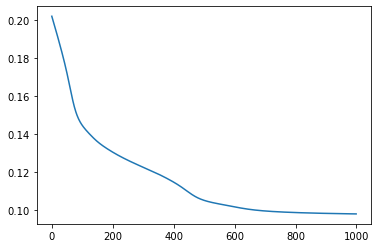

In [22]:
train(model, X_vec, Y_vec, n_epochs=1000, learning_rate=2.0)

Note that the loss value at the very end is significantly larger than before. Because each target word is not strictly matching to 1, 2 or any n context words. The training data always have 1-to-2 matching, which is never achievable, and not realistic.

In [23]:
# evaluation
print('Result after training:')
print('input   \t ground truth\t\t prediction')
for x_, y_, y_pred in zip(X,
                          Y,
                          nhot.inverse_transform(model.predict(X_vec),2)):
    print(x_, '\t', y_,'\t',y_pred, end='\t')
    for val in y_pred:
        if val not in y_:
            print('*')
            break
        else:
            pass
    else:
        print('')

Result after training:
input   	 ground truth		 prediction
['apple'] 	 ['drink', 'juice'] 	 ['juice', 'drink']	
['orange'] 	 ['eat', 'apple'] 	 ['apple', 'drink']	*
['rice'] 	 ['drink', 'juice'] 	 ['juice', 'drink']	
['juice'] 	 ['drink', 'milk'] 	 ['apple', 'drink']	*
['milk'] 	 ['drink', 'rice'] 	 ['drink', 'rice']	
['water'] 	 ['drink', 'milk'] 	 ['milk', 'drink']	
['juice'] 	 ['orange', 'apple'] 	 ['apple', 'drink']	*
['juice'] 	 ['apple', 'drink'] 	 ['apple', 'drink']	
['milk'] 	 ['rice', 'drink'] 	 ['drink', 'rice']	
['drink'] 	 ['milk', 'water'] 	 ['water', 'juice']	*
['drink'] 	 ['water', 'juice'] 	 ['water', 'juice']	
['drink'] 	 ['juice', 'water'] 	 ['water', 'juice']	


Same as before, the prediction cannot match ground truth perfectly, we have to look closer to each prediction.

With that being said, the prediction follows language intuition. E.g. the 4th line, 'juice' predicts 'drink' and 'apple', both are reasonable; however, in the ground truth, 'milk' is most likely a noise input.

In [24]:
word = 'eat'   # change this

print('The prediction scores for the word "{}":\n'.format(word))
print('--output--\t--score--')
scores = model.predict(ohot.transform([[word]]))[0]
for label_, score_ in zip(vocab, scores):
    print(label_, '\t{:.4f}'.format(score_), end='\t')
    if score_ > 1.0/8: print('*')
    else: print()

The prediction scores for the word "eat":

--output--	--score--
['apple'] 	0.0160	
['drink'] 	0.7633	*
['eat'] 	0.0047	
['juice'] 	0.1862	*
['milk'] 	0.0056	
['orange'] 	0.0051	
['rice'] 	0.0122	
['water'] 	0.0070	


The word 'water' have multiple relations in the training data, however it only predicts 'drink' with high accuracy.

On the other hand, the word 'eat' outputs 2 dominant relations 'drink' and 'juice', the latter one is confusing.

These may due to the bias of the training data (examine training samples with 'eat'), and the network follows suit.

## 3.3 - Visualize Encoding
Here we build another model that is identical to the left half of the neural network. Its output will be the encoding of given word.

In [25]:
#
enc_model = tf.keras.Model(inputs=model.input,
                           outputs=model.get_layer('encoder').output)

vocab_enc = enc_model.predict(ohot.transform(vocab))
print('Encoding of all 8 words:', vocab_enc.shape)

word = 'eat'
print('\nEncoding for the word "{}":'.format(word))
print(enc_model.predict(ohot.transform([[word]])))
# print(X_enc)

Encoding of all 8 words: (8, 2)

Encoding for the word "eat":
[[ 0.46061835 -0.30613163]]


This 2D encoding shows word relationship.


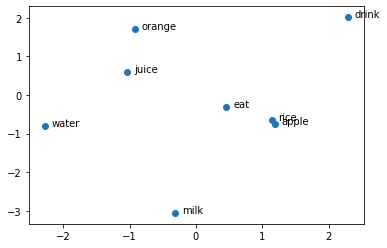

In [26]:
plot_enc_2d(vocab_enc, vocab)
print('This 2D encoding shows word relationship.')

This time, things are not that clear, e.g. 'water', 'milk', juice' are split apart, and so are 'apple' and 'orange'. This may due to lack of training data. 

On the good side, this result is consistant with the wevi webpage demo.

# CBOW and others
CBOW is simple swap the input and output of skip-gram, and will not be shown here.

Thanks for reading.